## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

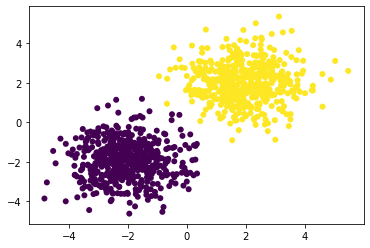

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

net

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

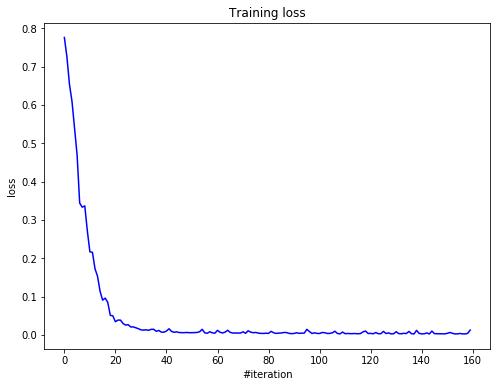

Current loss: 0.012367


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [70]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [9]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y = np.concatenate([y_train, y_val, y_test])
print(y.shape)
one_hot = np.asarray(encoder.fit_transform(y.reshape(-1, 1)).todense())
print(one_hot.shape)

y_train = one_hot[0:len(y_train)]
y_val = one_hot[len(y_train):len(y_train)+len(y_val)]
y_test = one_hot[len(y_train)+len(y_val):len(y_train)+len(y_val)+len(y_test)]

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
print(X_train.shape)
print(X_val.shape) 
print(X_test.shape)

(70000,)
(70000, 10)
(50000, 10)
(10000, 10)
(10000, 10)
(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [10]:
# Your code goes here. ################################################
def accur(y_data, y_pred):
    res = 0
    for i in range(len(y_data)):
        data = np.argmax(y_data[i])
        pred = np.argmax(y_pred[i])
        if data == pred:
            res += 1
    res /= len(y_data)
    return res

In [11]:
def net_tester(net_set, n_epoch):
    losses = {}
    counter = 0
    for net in net_set:
        counter += 1
        optimizer_state = {}
        loss_history = []
    
        for i in range(n_epoch):
            for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
                net.zeroGradParameters()

                # Forward
                predictions = net.forward(x_batch)
                loss = criterion.forward(predictions, y_batch)

                # Backward
                dp = criterion.backward(predictions, y_batch)
                net.backward(x_batch, dp)

                # Update weights
                sgd_momentum(net.getParameters(), 
                             net.getGradParameters(), 
                             optimizer_config,
                             optimizer_state)      

                loss_history.append(loss)
            print("Epoch:", i)
            print('Accuracy train: ', accur(net.forward(X_train), y_train))
            print('Accuracy val: ', accur(net.forward(X_val), y_val))
                
        losses.update({counter:loss_history})
        print('--------------------------------------------------------')
    # Visualize
        
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.ylim(0, 2.5)
    plt.plot(losses[1], 'b', label='loss')
    plt.plot(losses[2], 'r', label='loss, net using batchNorm')
    plt.legend()
    plt.show()
        
    return loss_history

Flatten
Linear 784 -> 50
ReLU
Linear 50 -> 10
LogSoftMax

Flatten
Linear 784 -> 50
BatchNormalization
ChannelwiseScaling
ReLU
Linear 50 -> 10
LogSoftMax

ReLU testing
Epoch: 0
Accuracy train:  0.89308
Accuracy val:  0.9038
Epoch: 1
Accuracy train:  0.91498
Accuracy val:  0.9223
Epoch: 2
Accuracy train:  0.92762
Accuracy val:  0.9314
Epoch: 3
Accuracy train:  0.93448
Accuracy val:  0.9375
Epoch: 4
Accuracy train:  0.9439
Accuracy val:  0.9465
--------------------------------------------------------
Epoch: 0
Accuracy train:  0.90752
Accuracy val:  0.9147
Epoch: 1
Accuracy train:  0.93398
Accuracy val:  0.9386
Epoch: 2
Accuracy train:  0.94826
Accuracy val:  0.9493
Epoch: 3
Accuracy train:  0.95796
Accuracy val:  0.9565
Epoch: 4
Accuracy train:  0.96258
Accuracy val:  0.958
--------------------------------------------------------


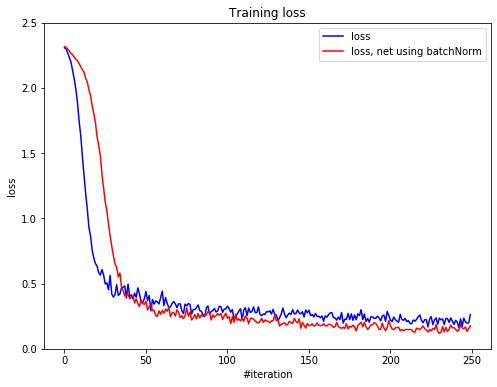

Accuracy score: 0.9406
Accuracy score (using batchNorm): 0.9587


In [12]:
# Looping params
n_epoch = 5

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 50))
net.add(ReLU())
net.add(Linear(50, 10))
net.add(LogSoftMax())

print(net)

net2 = Sequential()
net2.add(Flatten())
net2.add(Linear(784, 50))
net2.add(BatchNormalization(0.9))
net2.add(ChannelwiseScaling(50))
net2.add(ReLU())
net2.add(Linear(50, 10))
net2.add(LogSoftMax())

print(net2)

print('ReLU testing')
batch_size = 1000
net_tester((net,net2), n_epoch)

data = net.forward(X_test)
pred = y_test
print("Accuracy score:", accur(data, pred))

data2 = net2.forward(X_test)
pred2 = y_test
print("Accuracy score (using batchNorm):", accur(data2, pred2))

Flatten
Linear 784 -> 50
ELU
Linear 50 -> 10
LogSoftMax

Flatten
Linear 784 -> 50
BatchNormalization
ChannelwiseScaling
ELU
Linear 50 -> 10
LogSoftMax

ELU testing
Epoch: 0
Accuracy train:  0.89456
Accuracy val:  0.9014
Epoch: 1
Accuracy train:  0.91262
Accuracy val:  0.9181
Epoch: 2
Accuracy train:  0.92446
Accuracy val:  0.9274
Epoch: 3
Accuracy train:  0.93148
Accuracy val:  0.9367
Epoch: 4
Accuracy train:  0.93946
Accuracy val:  0.9426
--------------------------------------------------------
Epoch: 0
Accuracy train:  0.906
Accuracy val:  0.9125
Epoch: 1
Accuracy train:  0.92914
Accuracy val:  0.9319
Epoch: 2
Accuracy train:  0.94104
Accuracy val:  0.9432
Epoch: 3
Accuracy train:  0.94988
Accuracy val:  0.9482
Epoch: 4
Accuracy train:  0.956
Accuracy val:  0.9522
--------------------------------------------------------


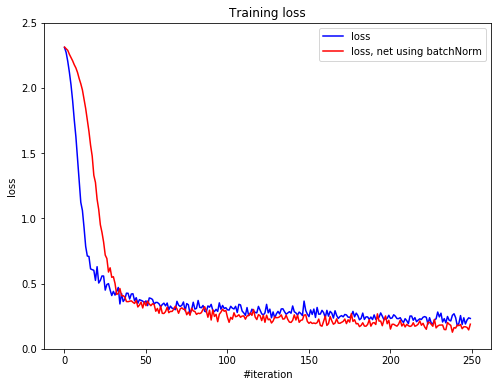

Accuracy score: 0.9352
Accuracy score (using batchNorm): 0.9491


In [13]:
# Looping params
n_epoch = 5

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 50))
net.add(ELU())
net.add(Linear(50, 10))
net.add(LogSoftMax())

print(net)

net2 = Sequential()
net2.add(Flatten())
net2.add(Linear(784, 50))
net2.add(BatchNormalization(0.9))
net2.add(ChannelwiseScaling(50))
net2.add(ELU())
net2.add(Linear(50, 10))
net2.add(LogSoftMax())

print(net2)

print('ELU testing')
batch_size = 1000
net_tester((net,net2), n_epoch)

data = net.forward(X_test)
pred = y_test
print("Accuracy score:", accur(data, pred))

data2 = net2.forward(X_test)
pred2 = y_test
print("Accuracy score (using batchNorm):", accur(data2, pred2))

Flatten
Linear 784 -> 50
LeakyReLU
Linear 50 -> 10
LogSoftMax

Flatten
Linear 784 -> 50
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 50 -> 10
LogSoftMax

LeakyReLU testing
Epoch: 0
Accuracy train:  0.89594
Accuracy val:  0.9055
Epoch: 1
Accuracy train:  0.91558
Accuracy val:  0.9209
Epoch: 2
Accuracy train:  0.92826
Accuracy val:  0.9317
Epoch: 3
Accuracy train:  0.93776
Accuracy val:  0.9411
Epoch: 4
Accuracy train:  0.94386
Accuracy val:  0.9458
--------------------------------------------------------
Epoch: 0
Accuracy train:  0.90374
Accuracy val:  0.9104
Epoch: 1
Accuracy train:  0.9296
Accuracy val:  0.9306
Epoch: 2
Accuracy train:  0.94372
Accuracy val:  0.9438
Epoch: 3
Accuracy train:  0.951
Accuracy val:  0.9506
Epoch: 4
Accuracy train:  0.95806
Accuracy val:  0.9543
--------------------------------------------------------


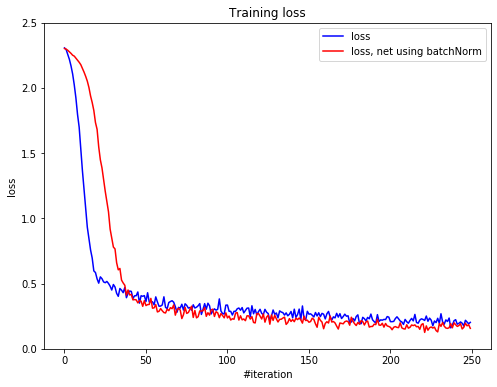

Accuracy score: 0.9435
Accuracy score (using batchNorm): 0.9523


In [14]:
# Looping params
n_epoch = 5

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 50))
net.add(LeakyReLU())
net.add(Linear(50, 10))
net.add(LogSoftMax())

print(net)

net2 = Sequential()
net2.add(Flatten())
net2.add(Linear(784, 50))
net2.add(BatchNormalization(0.9))
net2.add(ChannelwiseScaling(50))
net2.add(LeakyReLU())
net2.add(Linear(50, 10))
net2.add(LogSoftMax())

print(net2)

print('LeakyReLU testing')
batch_size = 1000
net_tester((net,net2), n_epoch)

data = net.forward(X_test)
pred = y_test
print("Accuracy score:", accur(data, pred))

data2 = net2.forward(X_test)
pred2 = y_test
print("Accuracy score (using batchNorm):", accur(data2, pred2))

Flatten
Linear 784 -> 50
SoftPlus
Linear 50 -> 10
LogSoftMax

Flatten
Linear 784 -> 50
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 50 -> 10
LogSoftMax

SoftPlus testing
Epoch: 0
Accuracy train:  0.88202
Accuracy val:  0.895
Epoch: 1
Accuracy train:  0.91004
Accuracy val:  0.9155
Epoch: 2
Accuracy train:  0.92076
Accuracy val:  0.9269
Epoch: 3
Accuracy train:  0.92952
Accuracy val:  0.9347
Epoch: 4
Accuracy train:  0.93558
Accuracy val:  0.9404
--------------------------------------------------------
Epoch: 0
Accuracy train:  0.89472
Accuracy val:  0.9072
Epoch: 1
Accuracy train:  0.92886
Accuracy val:  0.9323
Epoch: 2
Accuracy train:  0.93982
Accuracy val:  0.9406
Epoch: 3
Accuracy train:  0.95172
Accuracy val:  0.9502
Epoch: 4
Accuracy train:  0.95596
Accuracy val:  0.9522
--------------------------------------------------------


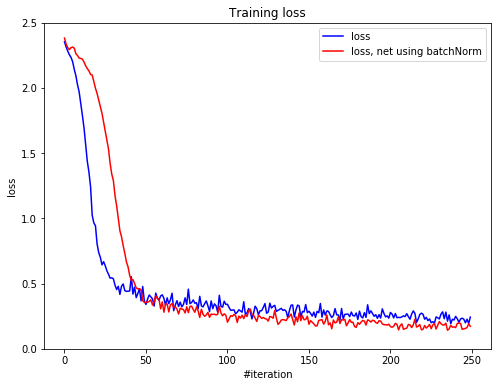

Accuracy score: 0.9366
Accuracy score (using batchNorm): 0.951


In [15]:
# Looping params
n_epoch = 5

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 50))
net.add(SoftPlus())
net.add(Linear(50, 10))
net.add(LogSoftMax())

print(net)

net2 = Sequential()
net2.add(Flatten())
net2.add(Linear(784, 50))
net2.add(BatchNormalization(0.9))
net2.add(ChannelwiseScaling(50))
net2.add(SoftPlus())
net2.add(Linear(50, 10))
net2.add(LogSoftMax())

print(net2)

print('SoftPlus testing')
batch_size = 1000
net_tester((net,net2), n_epoch)

data = net.forward(X_test)
pred = y_test
print("Accuracy score:", accur(data, pred))

data2 = net2.forward(X_test)
pred2 = y_test
print("Accuracy score (using batchNorm):", accur(data2, pred2))

### Middle summary:
As we can see best accuracy we got using ReLU. Moreover in each experiment it is obvious that including BatchNormalization with ChannelwiseScaling helped to get a little better accuracy.
Next lets see what will happen if we use Adam trainer with this ReLU.

In [16]:
def net_tester_adam(net_set, n_epoch):
    losses = {}
    counter = 0
    for net in net_set:
        counter += 1
        optimizer_state = {}
        loss_history = []
    
        for i in range(n_epoch):
            for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
                net.zeroGradParameters()

                # Forward
                predictions = net.forward(x_batch)
                loss = criterion.forward(predictions, y_batch)

                # Backward
                dp = criterion.backward(predictions, y_batch)
                net.backward(x_batch, dp)

                # Update weights
                adam_optimizer(net.getParameters(), 
                             net.getGradParameters(), 
                             optimizer_config,
                             optimizer_state)      

                loss_history.append(loss)
                
            print("Epoch:", i)
            print('Accuracy train: ', accur(net.forward(X_train), y_train))
            print('Accuracy val: ', accur(net.forward(X_val), y_val))
        print('-----------------------------------------------------')    
                
        losses.update({counter:loss_history})
    
    # Visualize
        
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.ylim(0, 2.5)
    plt.plot(losses[1], 'b', label='loss')
    plt.plot(losses[2], 'r', label='loss, net using batchNorm')
    plt.legend()
    plt.show()
        
    return loss_history

Flatten
Linear 784 -> 50
ReLU
Linear 50 -> 10
LogSoftMax

Flatten
Linear 784 -> 50
BatchNormalization
ChannelwiseScaling
ReLU
Linear 50 -> 10
LogSoftMax

ReLU testing
Epoch: 0
Accuracy train:  0.8572
Accuracy val:  0.8673
Epoch: 1
Accuracy train:  0.90398
Accuracy val:  0.9082
Epoch: 2
Accuracy train:  0.9145
Accuracy val:  0.9171
Epoch: 3
Accuracy train:  0.92594
Accuracy val:  0.923
Epoch: 4
Accuracy train:  0.9343
Accuracy val:  0.9309
-----------------------------------------------------
Epoch: 0
Accuracy train:  0.94632
Accuracy val:  0.9472
Epoch: 1
Accuracy train:  0.964
Accuracy val:  0.9615
Epoch: 2
Accuracy train:  0.97356
Accuracy val:  0.9641
Epoch: 3
Accuracy train:  0.97598
Accuracy val:  0.9629
Epoch: 4
Accuracy train:  0.97696
Accuracy val:  0.9625
-----------------------------------------------------


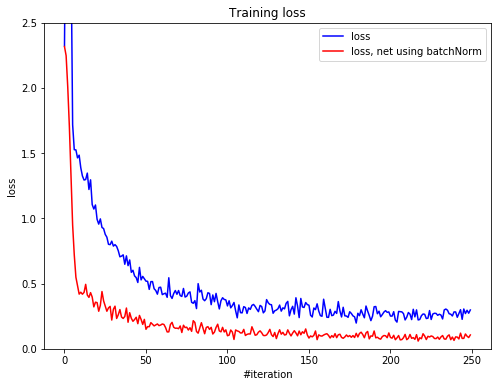

Accuracy score: 0.9308
Accuracy score (using batchNorm): 0.9619


In [17]:
# Looping params
n_epoch = 5
# Optimizer params
optimizer_config = {'learning_rate': 1e-1, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 50))
net.add(ReLU())
net.add(Linear(50, 10))
net.add(LogSoftMax())

print(net)

net2 = Sequential()
net2.add(Flatten())
net2.add(Linear(784, 50))
net2.add(BatchNormalization(0.9))
net2.add(ChannelwiseScaling(50))
net2.add(ReLU())
net2.add(Linear(50, 10))
net2.add(LogSoftMax())

print(net2)

print('ReLU testing')
batch_size = 1000
net_tester_adam((net,net2), n_epoch)

data = net.forward(X_test)
pred = y_test
print("Accuracy score:", accur(data, pred))

data2 = net2.forward(X_test)
pred2 = y_test
print("Accuracy score (using batchNorm):", accur(data2, pred2))

### Middle summary:
Well, actually while using adam optimizer we see that its accuracy is worse than sgd_momentum, but in opposite it gives better accuracy if we use BatchNormalization with ChannelwiseScaling

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

**Ответ**

Actually BatchNormalization helped but just to gather sometimes even less than 1% of accuracy. But using Adam it really halped to gather around 6% extra in accuracy.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Flatten
Linear 784 -> 50
BatchNormalization
ChannelwiseScaling
ReLU
Linear 50 -> 10
Dropout
LogSoftMax

ReLU testing
Epoch: 0
Accuracy train:  0.90882
Accuracy val:  0.9127
Epoch: 1
Accuracy train:  0.92372
Accuracy val:  0.9211
Epoch: 2
Accuracy train:  0.92902
Accuracy val:  0.927
Epoch: 3
Accuracy train:  0.92914
Accuracy val:  0.9247
Epoch: 4
Accuracy train:  0.92962
Accuracy val:  0.9257
-----------------------------------------------------


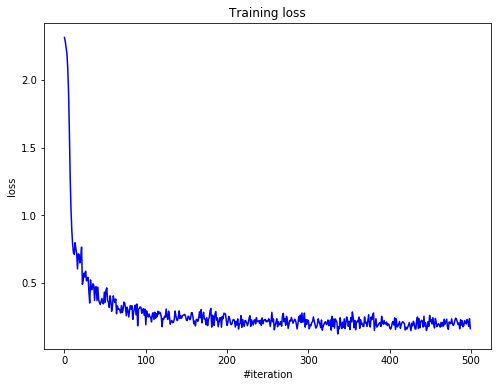

Accuracy score: 0.961


In [18]:
# Your code goes here. ################################################

# Optimizer params
optimizer_config = {'learning_rate' : 1, 'momentum': 0.9}

def net_tester_final(net, n_epoch):
    optimizer_state = {}
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            optimizer_config['learning_rate'] *= 0.99
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)
        print("Epoch:", i)
        print('Accuracy train: ', accur(net.forward(X_train), y_train))
        print('Accuracy val: ', accur(net.forward(X_val), y_val))
    
    print('-----------------------------------------------------') 
            
    net.evaluate()
                
    # Visualize
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
        
    return loss_history

# lets build our cool net
net = Sequential()
net.add(Flatten())
net.add(Linear(784, 50))
net.add(BatchNormalization(0.9))
net.add(ChannelwiseScaling(50))
net.add(ReLU())
net.add(Linear(50, 10))
net.add(Dropout(0.1))
net.add(LogSoftMax())

print(net)

print('ReLU testing')
batch_size = 500
net_tester_final(net, n_epoch)

data = net.forward(X_test)
pred = y_test
print("Accuracy score:", accur(data, pred))

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [68]:
from torch import nn
from torch import optim
import torch
model = nn.Sequential(
    nn.Linear(784, 256),
    nn.BatchNorm1d(256),
    nn.ELU(),
    nn.Dropout(),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ELU(),
    nn.Dropout(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1)
)

In [69]:
n_epochs = 20
batch_size = 128

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_history = []
model.train(True)
for i in range(n_epochs):
    for x_batch, y_batch in get_batches((torch.FloatTensor(X_train), torch.Tensor(y_train)), batch_size):
        
        optimizer.zero_grad()
        
        predictions = model.forward(x_batch)
        # loss = criterion(predictions, y_batch)
        loss = criterion(predictions, torch.max(y_batch, 1)[1])
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss)
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss) 

RuntimeError: size mismatch, m1: [3584 x 28], m2: [784 x 256] at ../aten/src/TH/generic/THTensorMath.cpp:41

In [ ]:
model.eval()
answers, labels = [], []
with torch.no_grad():
  for x_batch, y_batch in get_batches((X_test, torch.Tensor(y_test)), batch_size):
    predictions = model.forward(torch.FloatTensor(x_batch))
    prediction = predictions.argmax(axis=1).reshape(-1, 1)
    answers.append(prediction)
    labels.append(y_batch.reshape(-1, 1))

answers = np.vstack(answers)
labels = np.vstack(labels)

In [67]:
from sklearn.metrics import accuracy_score
print(accuracy_score(answers, labels))

NameError: name 'answers' is not defined